<a href="https://www.kaggle.com/code/nicost312/two-branch-inception-v3?scriptVersionId=181066022" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import gc
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import json

2024-06-02 08:59:04.075993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 08:59:04.076086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 08:59:04.233369: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version:  2.15.0
GPU is available


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
def split_data(dataset, train_size, valid_size, test_size):
  total_length = len(dataset)
  train_length = int(np.floor(total_length * train_size))
  valid_length = int(np.floor(total_length * valid_size))

  train_data = dataset.take(train_length)
  remaining = dataset.skip(train_length)
  valid_data = remaining.take(valid_length)
  test_data = remaining.skip(valid_length)

#   train_x = x[:train_breakpoint]
#   train_y = y[:train_breakpoint]
#   valid_x = x[train_breakpoint:valid_breakpoint]
#   valid_y = y[train_breakpoint:valid_breakpoint]
#   test_x = x[valid_breakpoint:]
#   test_y = y[valid_breakpoint:]

  return train_data, valid_data, test_data

In [5]:
def convert_to_lab(image):
    image = np.array(image)
    # OpenCV's 'cvtColor' function expects the input image to be in the BGR color space,
    # so we need to convert from RGB to BGR first
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Now we can convert from BGR to CIE L*a*b*
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)

    return image_lab

In [6]:
def preprocess_data(img, label, use_lab_color_space=True):
  img = tf.image.resize(img, (128, 128))
  img /= 255.

  if (use_lab_color_space):
    img = tf.py_function(func=color.rgb2lab, inp=[img], Tout=tf.float32)
    img = (img + [0, 128, 128]) / [100, 255, 255]
    
#     img = color.rgb2lab(img, channel_axis=2)
#     img[:, :, 0] = img[:, :, 0] / 100
#     img[:, :, 1:] = (img[:, :, 1:] + 128) / 255

  img.set_shape((128, 128, 3))
  label = tf.one_hot(label, depth=38)

  return img, label

In [7]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

# PLANT VILLAGE

In [8]:
# Construct a tf.data.Dataset
dataset, ds_info = tfds.load('plant_village',
              split="train",
              with_info=True,
              shuffle_files=True,
              as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteBT5B9J/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [9]:
dataset.shuffle(500)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
print(len(dataset))

54303


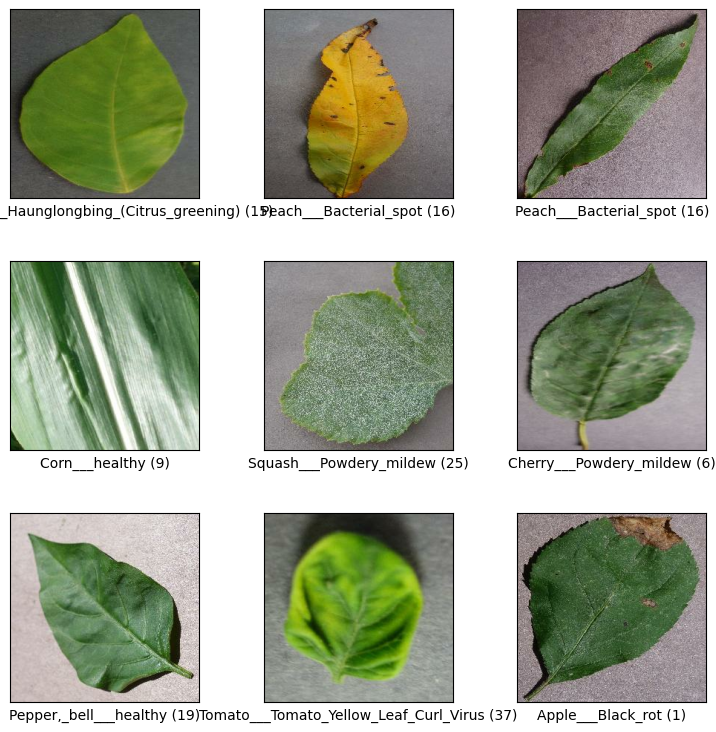

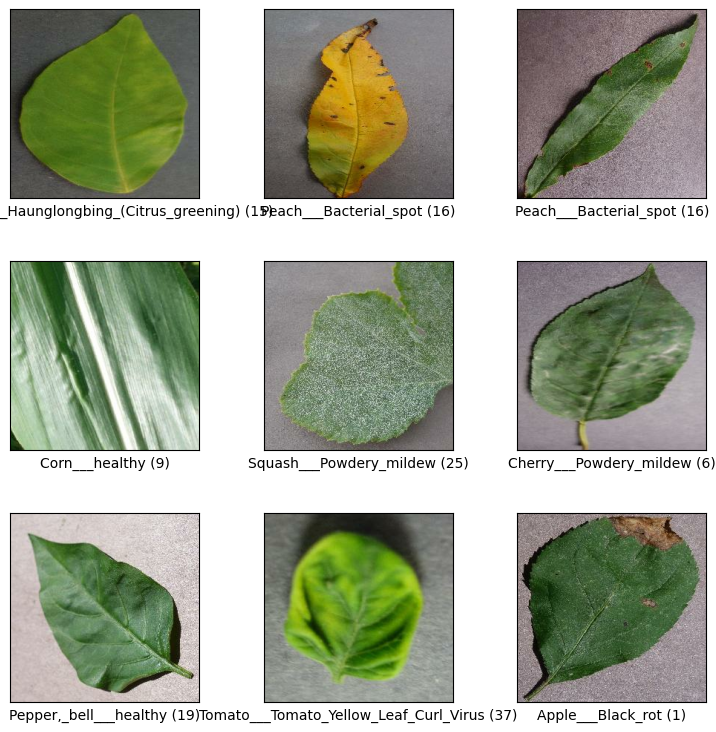

In [11]:
tfds.show_examples(dataset, ds_info)

In [12]:
dataset = dataset.map(preprocess_data)

[    0.          1586.824826   -2757.98260733]
[0. 1. 1.]


/tmp/ipykernel_34/36840112.py:17: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10880 negative Z values that have been clipped to zero
  ab_channel = color.lab2rgb(ab_channel)


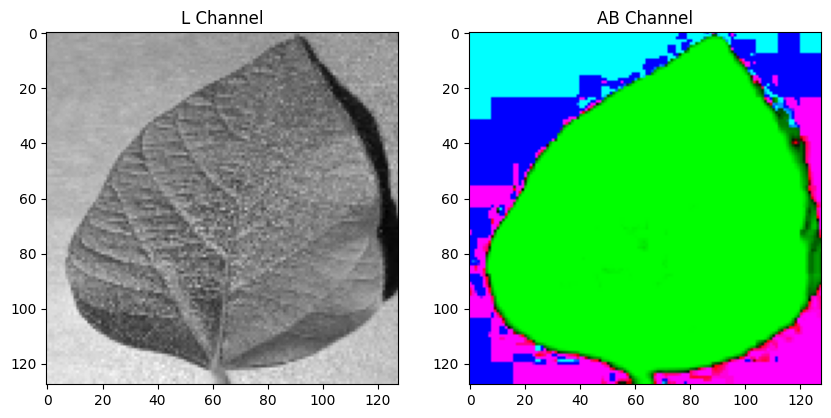

In [13]:
iterator = iter(dataset)
test= next(iterator)

# Search for data with early blight condition
if (np.argmax(test[1]) != 19):
    test = next(iterator)
    
test = np.copy(test[0])

l_channel = test[:, :, 0]

ab_channel = test[:, :, 1:]
ones_array = np.zeros((ab_channel.shape[0], ab_channel.shape[1], 1))
ab_channel = np.concatenate((ones_array, ab_channel), axis=2)
ab_channel = (ab_channel * [100, 255, 255] - [0, 128, 128]) * [0, 255, 255]
print(ab_channel[0][0])
ab_channel = color.lab2rgb(ab_channel)

print(ab_channel[0][0])

# Plot the image
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)
axs[0].imshow(l_channel, cmap='gray')
axs[0].set_title('L Channel')
axs[1].imshow(ab_channel)
axs[1].set_title('AB Channel')

# Show the plot
plt.show()

In [14]:
train_data, valid_data, test_data = split_data(
    dataset=dataset,
    train_size=0.6,
    valid_size=0.2,
    test_size=0.2
  )

In [15]:
print(len(train_data), len(valid_data), len(test_data))

32581 10860 10862


In [16]:
train_data = train_data.batch(32)
valid_data = valid_data.batch(32)

# TWO BRANCH INCEPTION V3

In [33]:
module_filters = [
    [64, 48, 64, 64, 96, 96, 32],
    [64, 48, 64, 64, 96, 96, 64],
    [64, 48, 64, 64, 96, 96, 64],
    [384, 64, 96, 96],
    [192, 128, 128, 192, 128, 128, 128, 128, 192, 192],
    [192, 160, 160, 192, 160, 160, 160, 160, 192, 192],
    [192, 192, 192, 192, 192, 192, 192, 192, 192, 192],
    [192, 192, 192, 192, 192, 192, 192, 192, 192, 192],
    [192, 320, 192, 192, 192, 192],
    [320, 384, 384, 384, 448, 384, 384, 384, 192],
    [320, 384, 384, 384, 448, 384, 384, 384, 192],
]

In [34]:
class CopyChannels(tf.keras.layers.Layer):
    """
    This layer copies channels from channel_start the number of channels given in channel_count.
    """
    def __init__(self,
                 channel_start=0,
                 channel_count=1,
                 **kwargs):
        self.channel_start=channel_start
        self.channel_count=channel_count
        super(CopyChannels, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.channel_count)

    def call(self, x):
        return x[:, :, self.channel_start:(self.channel_start+self.channel_count)]

    def get_config(self):
        config = {
            'channel_start': self.channel_start,
            'channel_count': self.channel_count
        }
        base_config = super(CopyChannels, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [35]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(scale=False)(x)
    return tf.keras.layers.Activation('relu')(x)

In [36]:
def inception_module_1(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2 = conv2d_bn(t2, filters[2], 3)

  t3 = conv2d_bn(x, filters[3], 1)
  t3 = conv2d_bn(t3, filters[4], 3)
  t3 = conv2d_bn(t3, filters[5], 3)

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[6], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [37]:
def inception_module_2(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2 = conv2d_bn(t2, filters[2], (1,7))
  t2 = conv2d_bn(t2, filters[3], (7,1))

  t3 = conv2d_bn(x, filters[4], 1)
  t3 = conv2d_bn(t3, filters[5], (1,7))
  t3 = conv2d_bn(t3, filters[6], (7,1))
  t3 = conv2d_bn(t3, filters[7], (1,7))
  t3 = conv2d_bn(t3, filters[8], (7,1))

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[9], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [38]:
def inception_module_3(x, filters):
  t1 = conv2d_bn(x, 384, 3)

  t2 = conv2d_bn(x, filters[1], 1)
  t2_1 = conv2d_bn(t2, filters[2], (1,3))
  t2_2 = conv2d_bn(t2, filters[3], (3,1))
  t2 = tf.keras.layers.concatenate([t2_1, t2_2], axis=3)

  t3 = conv2d_bn(x, filters[4], 1)
  t3 = conv2d_bn(t3, filters[5], 1)
  t3_1 = conv2d_bn(t3, filters[6], (1,3))
  t3_2 = conv2d_bn(t3, filters[7], (3,1))
  t3 = tf.keras.layers.concatenate([t3_1, t3_2], axis=3)

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[8], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [59]:
def grid_size_reduction_1(x, filters):
    t1 = conv2d_bn(x, filters[0], 3, strides=(2,2), padding="valid")

    t2 = conv2d_bn(x, filters[1], 1)
    t2 = conv2d_bn(t2, filters[2], 3)
    t2 = conv2d_bn(t2, filters[3], 3, strides=(2,2), padding="valid")

    t3 = tf.keras.layers.MaxPooling2D(3, strides=(2,2))(x)

    return tf.keras.layers.concatenate([t1, t2, t3], axis=3)

In [60]:
def grid_size_reduction_2(x, filters):
    t1 = conv2d_bn(x, filters[0], 1)
    t1 = conv2d_bn(t1, filters[1], 3, strides=(2,2), padding="valid")

    t2 = conv2d_bn(x, filters[2], 1)
    t2 = conv2d_bn(t2, filters[3], (1,7))
    t2 = conv2d_bn(t2, filters[4], (7,1))
    t2 = conv2d_bn(t2, filters[5], 3, strides=(2,2), padding="valid")

    t3 = tf.keras.layers.MaxPooling2D(3, strides=(2,2))(x)

    return tf.keras.layers.concatenate([t1, t2, t3], axis=3)

In [65]:
def two_path_inception_v3(
                include_top=True,
                include_first_block=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(128,128,3),
                pooling=None,
                classes=38,
                two_paths_partial_first_block=0,
                two_paths_first_block=False,
                l_ratio=0.2,
                ab_ratio=0.8,
                max_mix_idx=12,
                model_name='two_path_inception_v3',
                **kwargs):

    img_input = tf.keras.layers.Input(shape=input_shape)

    if include_first_block:
        if two_paths_first_block:
            if (l_ratio>0):
                l_branch = CopyChannels(0,1)(img_input)
                l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), (3, 3), strides=(2, 2), padding='valid')
                l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), (3, 3), padding='valid')
                l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), (3, 3))
                l_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            if (ab_ratio>0):
                ab_branch = CopyChannels(1,2)(img_input)
                ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), (3, 3), strides=(2, 2), padding='valid')
                ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), (3, 3), padding='valid')
                ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), (3, 3))
                ab_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            if (l_ratio>0):
                if (ab_ratio>0):
                    x = tf.keras.layers.Concatenate(axis=3, name='concat_first_block')([l_branch, ab_branch])
                else:
                    x = l_branch
            else:
                x = ab_branch
        else:
            single_branch = conv2d_bn(img_input, 32, (3, 3), strides=(2, 2), padding='valid')
            single_branch = conv2d_bn(single_branch, 32, (3, 3), padding='valid')
            single_branch = conv2d_bn(single_branch, 64, (3, 3))
            single_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)
            # print('single path first block')
            x = single_branch

    if max_mix_idx >= 0:
        for i in range(max_mix_idx):
          if i < 3:
            x = inception_module_1(x, module_filters[i])
          elif i == 3:
            x = grid_size_reduction_1(x, module_filters[i])
          elif i < 8:
            x = inception_module_2(x, module_filters[i])
          elif i == 8:
            x = grid_size_reduction_2(x, module_filters[i])
          else:
            x = inception_module_3(x, module_filters[i])

    if include_top:
        # Classification block
        x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = tf.keras.models.Model(inputs, x, name=model_name)
    return model

# EXPERIMENTS

In [74]:
checkpoint_path = "/kaggle/working/two_branch_inception_v3/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [42]:
print("Train data shape:", tf.data.experimental.cardinality(train_data).numpy())
print("Valid data shape:", tf.data.experimental.cardinality(valid_data).numpy())

Train data shape: 1019
Valid data shape: 340


In [43]:
# Inspect the shape of one element of train_data
for image, label in train_data.take(5):
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    

Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)
Image shape: (32, 128, 128, 3)
Label shape: (32, 38)


In [78]:
model = two_path_inception_v3(max_mix_idx=6)

In [67]:
model.summary()

Model: "two_path_inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_275 (Conv2D) │ (None, 63, 63,    │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d_275[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_275      │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_276 (Conv2D) │ (None, 61, 61,    │      9,216 │ activation_275[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_276[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_276      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_277 (Conv2D) │ (None, 61, 61,    │     18,432 │ activation_276[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_277[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_277      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 30, 30,    │          0 │ activation_277[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_281 (Conv2D) │ (None, 30, 30,    │      4,096 │ max_pooling2d_40… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        192 │ conv2d_281[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_281      │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_279 (Conv2D) │ (None, 30, 30,    │      3,072 │ max_pooling2d_40… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 30, 30,    │     55,296 │ activation_281[0… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        144 │ conv2d_279[0][0]

 Total params: 4,849,622 (18.50 MB)

 Trainable params: 4,838,646 (18.46 MB)

 Non-trainable params: 10,976 (42.88 KB)

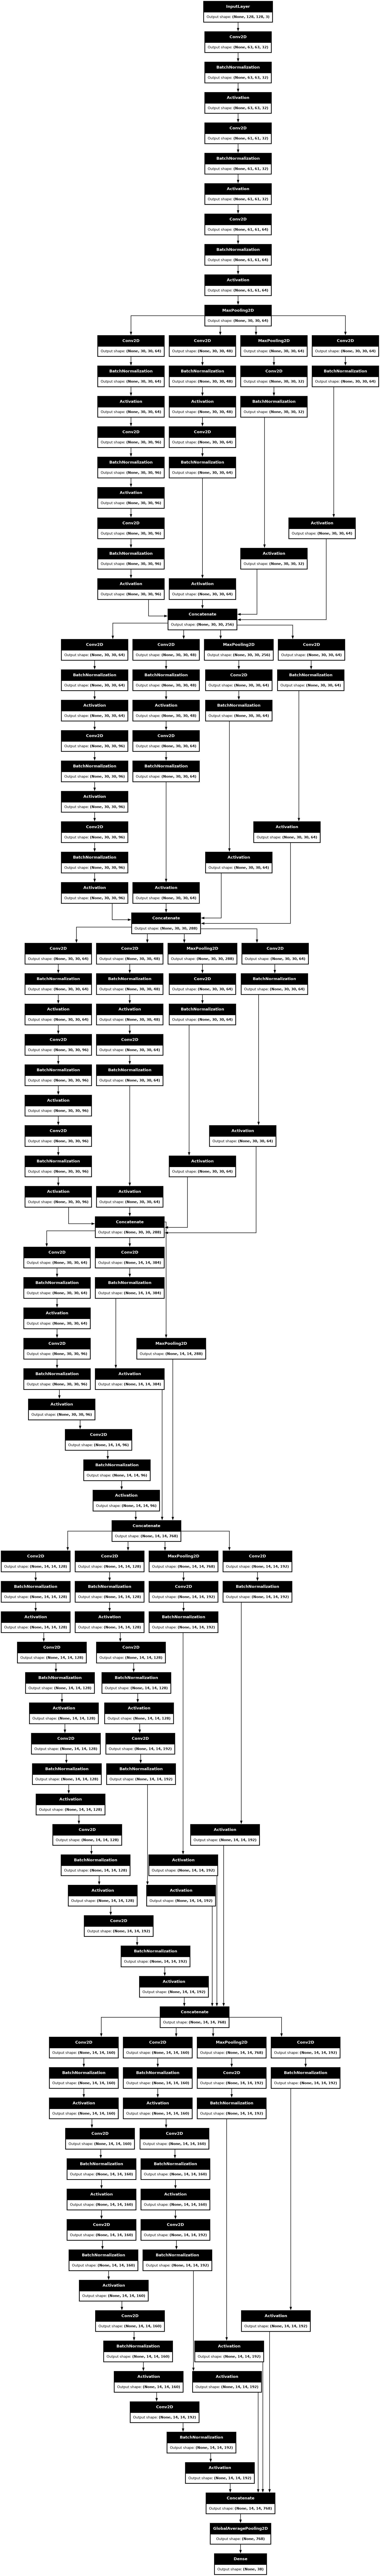

In [69]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [79]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        metrics=['accuracy'])

In [ ]:
monitor='val_accuracy'
epochs=10

history = model.fit(
    train_data,
    verbose=1,
    epochs=epochs,
    validation_data=valid_data,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
   1/1019 ━━━━━━━━━━━━━━━━━━━━ 14:29:58 51s/step - accuracy: 0.0312 - loss: 3.7880

W0000 00:00:1717322405.015830     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6450 - loss: 1.2749

W0000 00:00:1717322611.555911     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717322696.968199     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.88996
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 386s 329ms/step - accuracy: 0.6452 - loss: 1.2744 - val_accuracy: 0.6479 - val_loss: 1.3748
Epoch 2/10


W0000 00:00:1717322739.679996     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1018/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9322 - loss: 0.2188
Epoch 2: val_accuracy did not improve from 0.88996
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 320s 314ms/step - accuracy: 0.9322 - loss: 0.2187 - val_accuracy: 0.6530 - val_loss: 1.3347
Epoch 3/10
1018/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9578 - loss: 0.1283
Epoch 3: val_accuracy improved from 0.88996 to 0.89567, saving model to /kaggle/working/two_branch_inception_v3/cp-0003.keras
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 321s 315ms/step - accuracy: 0.9578 - loss: 0.1283 - val_accuracy: 0.8957 - val_loss: 0.3631
Epoch 4/10
1018/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9767 - loss: 0.0766
Epoch 4: val_accuracy improved from 0.89567 to 0.94208, saving model to /kaggle/working/two_branch_inception_v3/cp-0004.keras
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 320s 314ms/step - accuracy: 0.9767 - loss: 0.0765 - val_accuracy: 0.9421 - val_loss: 0.1770
Epoch 5/10
1018/1019 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0

In [ ]:
plot_loss_curves(history)